In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Deep_learning'

/content/drive/MyDrive/Deep_learning


In [11]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [10]:
class SoftmaxRegression(nn.Module):
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.lr = lr
        self.num_outputs = num_outputs
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))
    def forward(self, X):
        return self.net(X)

    def predict(self, X):
        return torch.argmax(self.net(X), dim = 1)

In [32]:
def train_epoch(net, dataloader, lr =0.01, optimizer = None, loss_fn = nn.NLLLoss(), device = 'cpu'):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
    net.train()
    total_loss, acc, count = 0, 0, 0
    for features, labels in dataloader:
        # Compute prediction error
        pred = net(features.to(device))
        lbls = labels.to(device)
        loss = loss_fn(pred, lbls)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss
        predicted = torch.argmax(pred, dim = 1)
        acc += (predicted == lbls).sum()
        count += len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader, loss_fn = nn.NLLLoss(), device = 'cpu'):
    net.eval()
    loss, acc, count = 0, 0, 0
    with torch.no_grad():
        for features, labels in dataloader:
            pred = net(features.to(device))
            lbls = labels.to(device)
            loss += loss_fn(pred, lbls)
            predicted = torch.argmax(pred, dim = 1)
            acc += (predicted == lbls).sum()
            count += len(labels)
        return loss.item()/count, acc.item()/count

def train(net, train_loader, test_loader = None, optimizer = None, lr = 0.01, epochs = 10, loss_fn = nn.NLLLoss(), device = 'cpu'):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
    res = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer = optimizer, lr = lr, loss_fn = loss_fn, device = device)
        if test_loader:
            vl, va = validate(net, test_loader, loss_fn = loss_fn, device = device)
            print(f"Epoch {ep:2}: Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
            res['val_loss'].append(vl)
            res['val_acc'].append(va)
        else:
            print(f"Epoch {ep:2}: Train acc={ta:.3f}, Train loss={tl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
    return res

def plot_results(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()

In [13]:
from torchvision import datasets
from torchvision import transforms

In [17]:
data_train = datasets.MNIST(
    root = './data',
    train = True,
    download = False,
    transform = transforms.ToTensor()
)

data_val = datasets.MNIST(
    root = './data',
    train = False,
    download = False,
    transform = transforms.ToTensor()
)

In [18]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size = 64, shuffle = True, pin_memory = True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size = 64, pin_memory = True)

In [20]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
net = SoftmaxRegression(num_outputs = 10, lr = 0.1)
from torchinfo import summary
summary(net, input_size = (1,1,28,28))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Output Shape              Param #
SoftmaxRegression                        [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 10]                   7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [24]:
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'
default_device

'cuda'

In [33]:
opt = torch.optim.SGD(net.parameters(), lr = net.lr, momentum = 0.9)
hist = train(net, train_loader, val_loader, optimizer = opt, epochs = 10, lr = net.lr, loss_fn = nn.CrossEntropyLoss(), device = default_device)

Epoch  0: Train acc=0.917, Val acc=0.912, Train loss=0.005, Val loss=0.005
Epoch  1: Train acc=0.918, Val acc=0.910, Train loss=0.005, Val loss=0.005
Epoch  2: Train acc=0.920, Val acc=0.919, Train loss=0.005, Val loss=0.005
Epoch  3: Train acc=0.921, Val acc=0.915, Train loss=0.004, Val loss=0.005
Epoch  4: Train acc=0.920, Val acc=0.917, Train loss=0.004, Val loss=0.005
Epoch  5: Train acc=0.921, Val acc=0.920, Train loss=0.004, Val loss=0.005
Epoch  6: Train acc=0.921, Val acc=0.918, Train loss=0.004, Val loss=0.005
Epoch  7: Train acc=0.922, Val acc=0.921, Train loss=0.004, Val loss=0.005
Epoch  8: Train acc=0.922, Val acc=0.913, Train loss=0.004, Val loss=0.005
Epoch  9: Train acc=0.923, Val acc=0.911, Train loss=0.004, Val loss=0.005


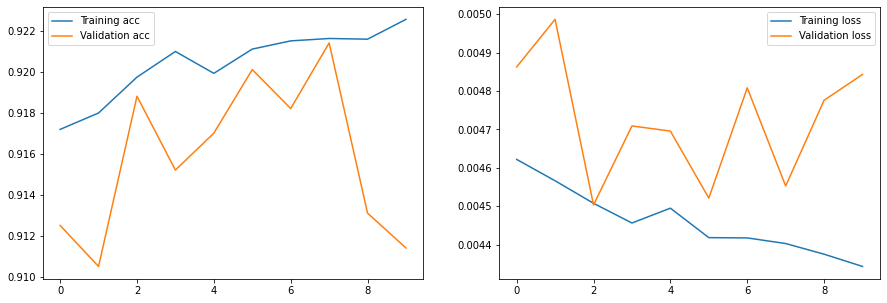

In [34]:
plot_results(hist)